In [22]:
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from file_process import process_genre_folder






In [8]:
print("test1")

test1


In [19]:
test_path = "../data/test"
test_df = process_genre_folder(test_path,lang="ch")


Processing genre: scifi
  Success: 1. 劉慈欣《三體》.txt                                     → 17,720 words
  Success: 2. 郝景芳-北京折叠.txt                                    → 2,406 words
  Success: 3.-劉慈欣《三體Ⅱ：黑暗森林》_1.txt                             → 29,043 words

Finished! Successfully processed 3/3 files.


In [20]:
test_df

,pronoun_ratio,info_density,avg_sent_len,language,total_words,book,genre,filepath
0,0.0,0.999774,553.750000,en,17720,1. 劉慈欣《三體》.txt,scifi,../data/test\scifi\1. 劉慈欣《三體》.txt
1,0.0,1.000000,1203.000000,en,2406,2. 郝景芳-北京折叠.txt,scifi,../data/test\scifi\2. 郝景芳-北京折叠.txt
2,0.0,0.999897,1075.666667,en,29043,3.-劉慈欣《三體Ⅱ：黑暗森林》_1.txt,scifi,../data/test\scifi\3.-劉慈欣《三體Ⅱ：黑暗森林》_1.txt


In [ ]:
chinese_path = "../data/chinese"  # ← Change to your folder path
english_path = "../data/english"

chinese_df = process_genre_folder(chinese_path,lang="ch")
english_df = process_genre_folder(english_path,lang="en")


Processing genre: history_fiction


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.602 seconds.
Prefix dict has been built successfully.


  Success: 1. 长安十二时辰 (马伯庸) (Z-Library).txt                    → 237,443 words
  Success: 10. 历史的裂变：中国历史上的十三场政变（畅销书《大唐兴亡三百年》作者王觉仁力作，用小说笔法，讲述 → 143,503 words
  Success: 2. 风起陇西 (马伯庸 [马伯庸]) (Z-Library).txt                → 142,867 words
  Success: 3. 隋乱 (酒徒) (Z-Library).txt                         → 1,170,142 words
  Success: 4. 新宋 (阿越) (Z-Library).txt                         → 1,738,158 words
  Success: 5. 步步生莲 (月关) (Z-Library).txt                       → 1,790,461 words


KeyboardInterrupt: 

In [ ]:
chinese_df

In [ ]:
english_df

In [4]:
import pandas as pd

def clean_df(df, verbose=True):
    initial = len(df)
    
    # 1. Remove only real garbage (NaN / inf / empty)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=["pronoun_ratio", "info_density", 
                           "avg_sent_len","total_words"])
    
    # 2. Minimum realistic book size (skip samples/chapters)
    df = df[df["total_words"] >= 10_000]   # ← 10k words minimum (very safe)
    
    # 3. VERY LOOSE outlier removal — use 5×IQR or percentile clipping
    numeric_cols = ["pronoun_ratio", "info_density", "avg_sent_len", "total_words"]
    
    for col in numeric_cols:
        if col == "total_words":
            # For word count: just cap at 99.5th percentile (some epics are huge)
            upper = df[col].quantile(0.995)
            removed = len(df[df[col] > upper])
            df = df[df[col] <= upper]
        else:
            # For all ratios: winsorize at 1% and 99% (keeps real variation)
            lower = df[col].quantile(0.01)
            upper = df[col].quantile(0.99)
            removed = len(df[(df[col] < lower) | (df[col] > upper)])
            df = df[df[col].between(lower, upper)]
            
        if verbose and removed > 0:
            print(f"  Removed {removed} extreme values in {col}")
    
    
    final = len(df)
    if verbose:
        print(f"\nData cleaning complete:")
        print(f"   Before → {initial} books")
        print(f"   After  → {final} books ({initial-final} removed)")
        print(f"   Kept {100*final/initial:.1f}% of the data\n")
    
    return df.reset_index(drop=True)

In [5]:
clean_ch_df = clean_df(chinese_df)

  Removed 1 extreme values in pronoun_ratio
  Removed 2 extreme values in info_density
  Removed 2 extreme values in avg_sent_len
  Removed 1 extreme values in total_words

Data cleaning complete:
   Before → 39 books
   After  → 33 books (6 removed)
   Kept 84.6% of the data



In [6]:
clean_en_df = clean_df(english_df)

  Removed 2 extreme values in pronoun_ratio
  Removed 2 extreme values in info_density
  Removed 2 extreme values in avg_sent_len
  Removed 1 extreme values in total_words

Data cleaning complete:
   Before → 40 books
   After  → 33 books (7 removed)
   Kept 82.5% of the data



In [7]:
features = ["pronoun_ratio","info_density","avg_sent_len"]	

In [8]:
ch_no = clean_ch_df[features].values
ch_no = (ch_no - ch_no.mean(axis=0)) / ch_no.std(axis=0)   # ← THIS IS THE NORMALIZATION

In [9]:
en_no = clean_en_df[features].values
en_no = (en_no - en_no.mean(axis=0)) / en_no.std(axis=0)   # ← THIS IS THE NORMALIZATION

In [10]:
pro_ch_df = clean_ch_df

In [11]:
# Give normalized values back to df
for i, col in enumerate(features):
    pro_ch_df[f"{col}"] = ch_no[:, i]

In [12]:
pro_en_df = clean_en_df

In [13]:
# Give normalized values back to df
for i, col in enumerate(features):
    pro_en_df[f"{col}"] = en_no[:, i]

In [14]:
df = pd.concat([pro_en_df, pro_ch_df], ignore_index=True)

In [15]:
df[df["language"]=="en"]

,pronoun_ratio,info_density,avg_sent_len,language,total_words,book,genre,filepath
0,-0.171983,0.092484,-0.542220,en,149359,The Nightingale - Kristin Hannah.txt,history_fiction,data/english/history_fiction/The Nightingale -...
1,1.449971,0.591529,-0.686259,en,101501,The Song of Achilles - Madeline Miller.txt,history_fiction,data/english/history_fiction/The Song of Achil...
2,0.659681,-0.146926,0.313272,en,217990,Wolf Hall - Hilary Mantel.txt,history_fiction,data/english/history_fiction/Wolf Hall - Hilar...
3,0.859820,-0.282631,0.446647,en,141904,Bring Up the Bodies - Hilary Mantel.txt,history_fiction,data/english/history_fiction/Bring Up the Bodi...
4,-2.034906,-1.152663,0.260240,en,129408,All the Light We Cannot See - Anthony Doerr.txt,history_fiction,data/english/history_fiction/All the Light We ...
5,-0.185790,-0.978990,2.468600,en,98781,March - Geraldine Brooks.txt,history_fiction,data/english/history_fiction/March - Geraldine...
6,-1.099893,-0.058152,-1.022488,en,126101,The Four Winds - Kristin Hannah.txt,history_fiction,data/english/history_fiction/The Four Winds - ...
7,0.594496,0.295437,-1.085424,en,97338,The Last House on Needless Street - Catriona W...,horror,data/english/horror/The Last House on Needless...
8,0.175483,0.419917,-0.179848,en,93523,Mexican Gothic - Silvia Moreno-Garcia.txt,horror,data/english/horror/Mexican Gothic - Silvia Mo...
9,-0.199026,-0.145501,-0.179606,en,206118,Duma Key - Stephen King.txt,horror,data/english/horror/Duma Key - Stephen King.txt


In [16]:
pca_df = df.dropna(subset=["pronoun_ratio", "info_density", "avg_sent_len"]).reset_index(drop=True)

# Now PCA will work perfectly
features = ["pronoun_ratio", "info_density", "avg_sent_len"]
pca_X = pca_df[features]

Explained variance ratio: [0.47185204 0.38845362]


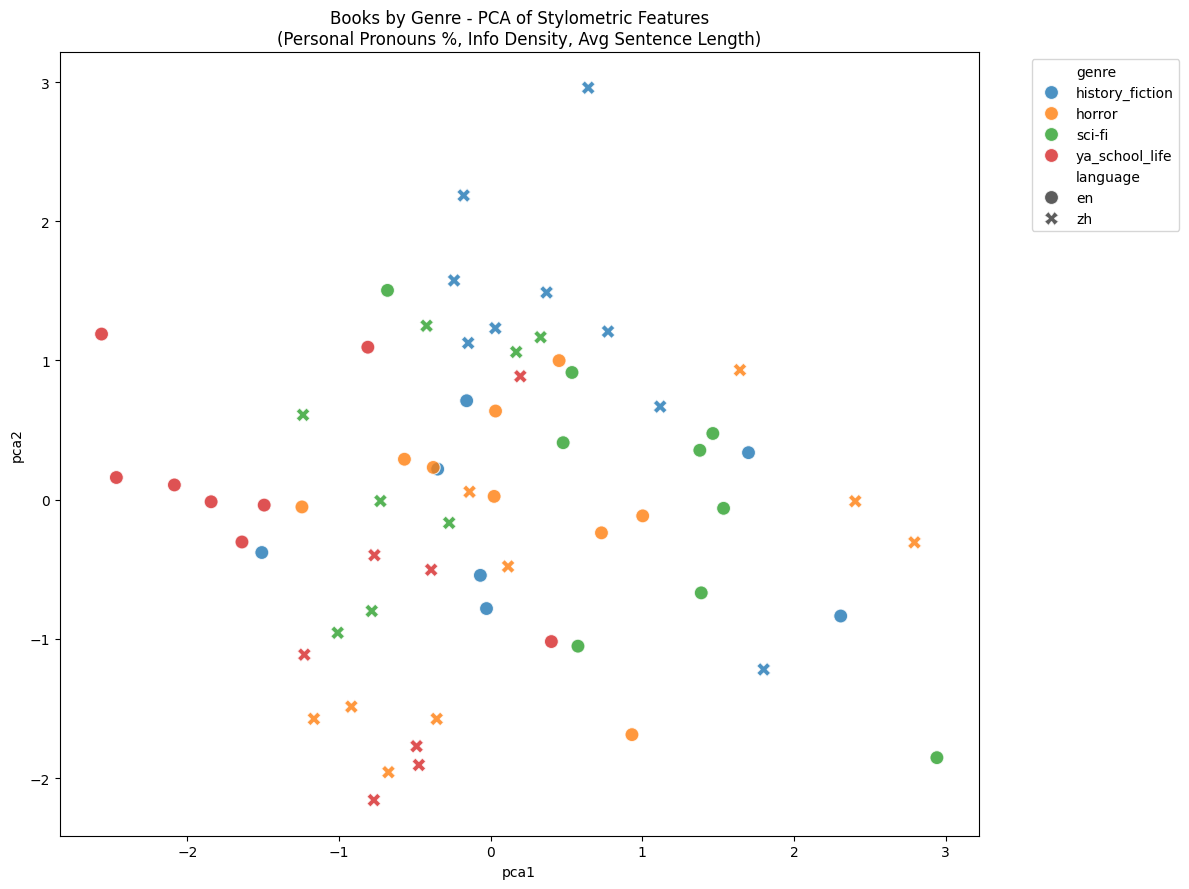

In [17]:
# Standardize
X_std = (pca_X - pca_X.mean()) / pca_X.std()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_std)
df["pca1"] = pca_result[:, 0]
df["pca2"] = pca_result[:, 1]

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# ----------------- Plot -----------------
plt.figure(figsize=(12, 9))
sns.scatterplot(
    data=df,
    x="pca1", y="pca2",
    hue="genre",
    style="language",
    s=100,
    alpha=0.8
)
plt.title("Books by Genre - PCA of Stylometric Features\n"
          "(Personal Pronouns %, Info Density, Avg Sentence Length)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save results
df.to_csv("analysis_with_pca.csv")


PEARSON CORRELATION: English vs Chinese Stylistic Similarity (by Genre)
             genre  n_en  n_zh  pearson_r  p_value  significant
3   ya_school_life     8     7     0.4319   0.7157        False
1           horror     9     9     0.3875   0.7467        False
0  history_fiction     7     9    -0.2224   0.8572        False
2           sci-fi     9     8    -0.8668   0.3324        False

Strong cross-language similarity (r > 0.7):
Empty DataFrame
Columns: [genre, pearson_r, n_en, n_zh]
Index: []


Text(0.5, 1.0, 'How Similar Are English & Chinese Books in the Same Genre?\nHigher r = More similar stylistic profile')

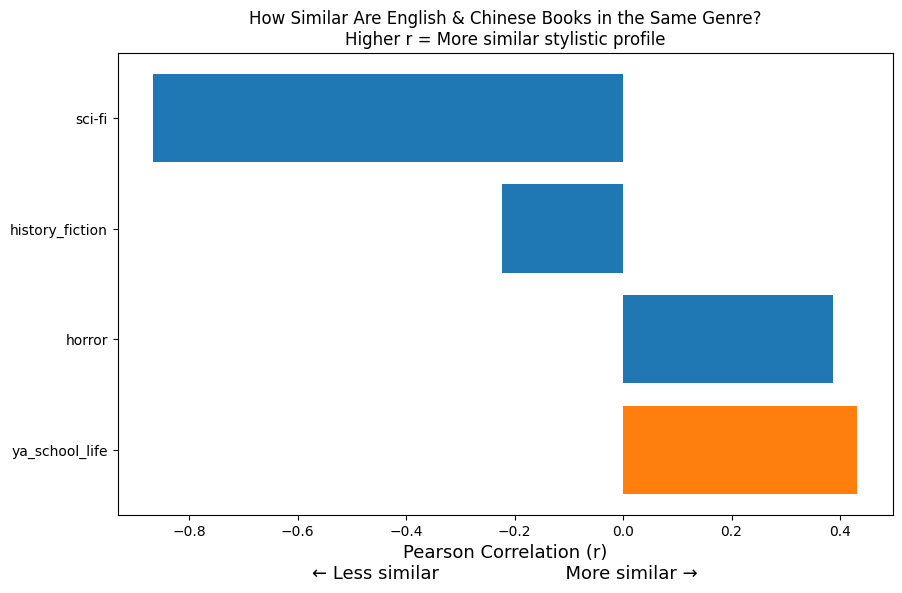

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# ────────────────────────
# 1. Normalize the 3 features (same as before)
# ────────────────────────
features = ["pronoun_ratio", "info_density", "avg_sent_len"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

X = df[features].values
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
for i, col in enumerate(features):
    df[f"{col}_norm"] = X_norm[:, i]

# Use only normalized features for comparison
norm_cols = [f"{f}_norm" for f in features]

# ────────────────────────
# 2. Pearson correlation: EN vs ZH within same genre
# ────────────────────────
results = []

for genre in df["genre"].unique():
    en_books = df[(df["genre"] == genre) & (df["language"] == "en")][norm_cols]
    zh_books = df[(df["genre"] == genre) & (df["language"] == "zh")][norm_cols]
    
    if len(en_books) < 2 or len(zh_books) < 2:
        print(f"Skipping {genre}: not enough books (EN={len(en_books)}, ZH={len(zh_books)})")
        continue
    
    # Average stylistic profile per language
    en_mean = en_books.mean()
    zh_mean = zh_books.mean()
    
    # Pearson correlation between the two average vectors
    r, p = pearsonr(en_mean, zh_mean)
    
    results.append({
        "genre": genre,
        "n_en": len(en_books),
        "n_zh": len(zh_books),
        "pearson_r": r,
        "p_value": p,
        "significant": p < 0.05
    })

# Convert to DataFrame
corr_df = pd.DataFrame(results)
corr_df = corr_df.sort_values("pearson_r", ascending=False)

# ────────────────────────
# 3. Display results
# ────────────────────────
print("\nPEARSON CORRELATION: English vs Chinese Stylistic Similarity (by Genre)")
print("="*80)
print(corr_df.round(4))

# Highlight strong similarity
print("\nStrong cross-language similarity (r > 0.7):")
print(corr_df[corr_df["pearson_r"] > 0.7][["genre", "pearson_r", "n_en", "n_zh"]])

# ────────────────────────
# 4. Beautiful bar plot
# ────────────────────────
plt.figure(figsize=(10, 6))
bars = plt.barh(corr_df["genre"], corr_df["pearson_r"], 
                color=np.where(corr_df["pearson_r"] > 0.7, "#d62728", 
                       np.where(corr_df["pearson_r"] > 0.4, "#ff7f0e", "#1f77b4")))

plt.xlabel("Pearson Correlation (r)\n← Less similar                      More similar →", fontsize=13)
plt.title("How Similar Are English & Chinese Books in the Same Genre?\n"
          "Higher r = More similar stylistic profile")

/tmp/ipykernel_25991/339572727.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


<Figure size 1200x800 with 0 Axes>

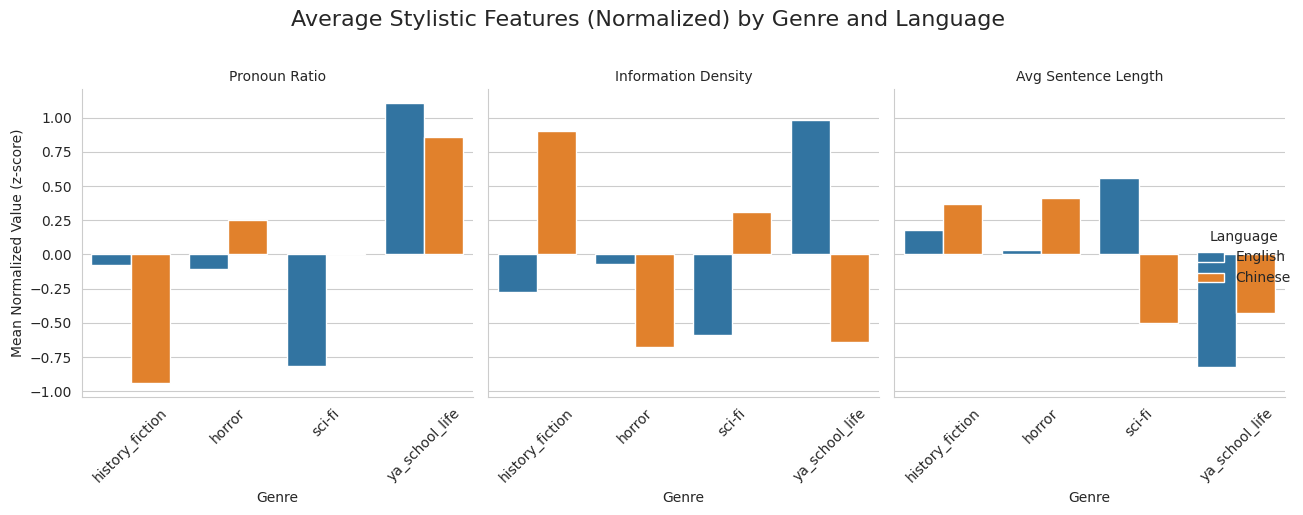

In [19]:
features = ["pronoun_ratio", "info_density", "avg_sent_len"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

X = df[features].values
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

for i, col in enumerate(features):
    df[f"{col}_norm"] = X_norm[:, i]

norm_cols = [f"{f}_norm" for f in features]

# ────────────────────────
# Compute mean normalized features per genre and language
# ────────────────────────
mean_df = (
    df.groupby(["genre", "language"])[norm_cols]
      .mean()
      .reset_index()
)

# Melt for easier plotting with seaborn
mean_melted = mean_df.melt(
    id_vars=["genre", "language"],
    value_vars=norm_cols,
    var_name="feature",
    value_name="mean_normalized_value"
)

# Clean up feature names for nicer display
feature_names = {
    "pronoun_ratio_norm": "Pronoun Ratio",
    "info_density_norm": "Information Density",
    "avg_sent_len_norm": "Avg Sentence Length"
}
mean_melted["feature"] = mean_melted["feature"].map(feature_names)

# ────────────────────────
# Plot: Grouped bar chart (EN vs ZH) per genre
# ────────────────────────
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
palette = {"en": "#1f77b4", "zh": "#ff7f0e"}  # Blue for EN, Orange for ZH

g = sns.catplot(
    data=mean_melted,
    kind="bar",
    x="genre",
    y="mean_normalized_value",
    hue="language",
    col="feature",
    palette=palette,
    height=5,
    aspect=0.8,
    ci=None,
    legend=False
)

# Customize
g.set_axis_labels("Genre", "Mean Normalized Value (z-score)")
g.set_titles("{col_name}")
g.add_legend(title="Language", labels=["English", "Chinese"])
g.fig.suptitle("Average Stylistic Features (Normalized) by Genre and Language", y=1.02, fontsize=16)

# Rotate x-labels if needed
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [20]:

# 5b – Grouped bar plot of average normalized values per genre
plot_df = mean_by_lang_genre.melt(id_vars=["genre", "language"], 
                                  value_vars=norm_cols,
                                  var_name="feature", 
                                  value_name="z=z_score")

# Clean feature names for legend
plot_df["feature"] = plot_df["feature"].str.replace("_norm", "").str.replace("_", " ").str.title()

plt.figure(figsize=(12, 8))
sns.barplot(data=plot_df, y="genre", x="z_score", hue="language",
            palette={"en": "#1f77b4", "zh": "#ff7f0e"}, orient="h")
plt.axvline(0, color="gray", linewidth=0.8)
plt.xlabel("Average Normalized Score (z-score)", fontsize=13)
plt.title("Average Stylistic Features (z-scores) – English vs Chinese by Genre", fontsize=15, pad=20)
plt.legend(title="Language", loc="lower right")
plt.tight_layout()
plt.show()

# 5c – Optional: Heatmap of absolute differences per feature
diff_plot = comparison_df.set_index("genre")[diff_cols].rename(columns=lambda x: x.replace("_diff", "").replace("_", " ").title())

plt.figure(figsize=(8, 6))
sns.heatmap(diff_plot.T, annot=True, cmap="YlOrRd", fmt=".2f", cbar_kws={'label': '|EN − ZH| (absolute difference)'})
plt.title("Absolute Differences in Stylistic Features\nbetween English and Chinese (by Genre)", pad=20)
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

NameError: name 'mean_by_lang_genre' is not defined